In [1]:
import pandas as pd
import os
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.preprocessing import scale, StandardScaler
import numpy as np
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

## EDA and Data Processing

In [2]:
df_i = pd.read_csv('heart.csv')

In [3]:
df_i.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,55,M,ASY,140,217,0,Normal,111,Y,5.6,Down,1
1,50,M,ASY,140,231,0,ST,140,Y,5.0,Flat,1
2,51,M,ASY,140,298,0,Normal,122,Y,4.2,Flat,1
3,61,M,ASY,120,282,0,ST,135,Y,4.0,Down,1
4,64,M,ASY,134,273,0,Normal,102,Y,4.0,Down,1


In [4]:
print('column labels = \n')
cols = df_i.columns
for i in cols:
    print(i)

column labels = 

Age
Sex
ChestPainType
RestingBP
Cholesterol
FastingBS
RestingECG
MaxHR
ExerciseAngina
Oldpeak
ST_Slope
HeartDisease


In [5]:
df_i.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

### Object columns needs encoded
#### OHE is chosen for all columns containing more than 2 categories and because all object columns contain nominal data.  Columns with binary values are label encoded.  I overlooked this until the first One Hot Encoding pass.

In [6]:
object_cols = df_i.select_dtypes(include='object') 
object_cols = list(object_cols.columns)

Legend = [] #keep a legend of label encoded columns
Labels = [] #used to bookkeep the legend

ohc = OneHotEncoder()
le = LabelEncoder()

data_ohc = df_i.copy()

for col in object_cols:
    dat = np.array(data_ohc[col])
    data_ohc = data_ohc.drop(col, axis=1) #drop this column name, look along column
    
    if df_i[col].nunique() == 2:
        new_dat = le.fit_transform(dat) #label encode binary valued columns
        data_ohc[col] = new_dat #overwrite columns
        Legend.append(np.array(le.classes_)) #keep track of what the encoding is
        Labels.append(col)
    else: 
        new_dat = ohc.fit_transform(dat.reshape(-1,1)) #ohc takes this [[], [], ..., []] format
        n_cols = new_dat.shape[1] #grab the number of OHC columns
        feature_names = ohc.get_feature_names()
        feature_names = [i.split('_')[-1] for i in feature_names] #clean up new column names
        col_names = ['_'.join([col, str(x)]) for x in feature_names] #clean up new column names

        new_df = pd.DataFrame(new_dat.toarray(), 
                              index=data_ohc.index,
                              columns=col_names)

        data_ohc = pd.concat([data_ohc, new_df],axis=1) #axis = 1 tells it to join on index.  Omission appends dfs rowwise


df_legend = pd.DataFrame(Legend, index = Labels)

df_legend = df_legend.transpose()

In [7]:
#in case we need a reference for what the label encoded values are
df_legend

,Sex,ExerciseAngina
0,F,N
1,M,Y


### Let's have a look at which features are most strongly correllated with the target.

In [8]:
df_corr = data_ohc.corr()
target_corr = df_corr.HeartDisease.sort_values(ascending = False).to_frame()

target_corr.drop('HeartDisease')


,HeartDisease
ST_Slope_Flat,0.554134
ChestPainType_ASY,0.516716
ExerciseAngina,0.494282
Oldpeak,0.403951
Sex,0.305445
Age,0.282039
FastingBS,0.267291
ST_Slope_Down,0.122527
RestingBP,0.107589
RestingECG_ST,0.102527


In [9]:
#Cell to write out data, if needed

#data_ohc.to_csv('encoded_data.csv')
#df_corr.to_csv('correlations.csv')

In [10]:
#sns.pairplot(df_i.drop(['FastingBS'], axis = 1)) #the scatter plots of the OHE data didn't seem useful. Also dropped the fasting bs column

In [11]:
df_NC = data_ohc[data_ohc['Cholesterol']==0] #subset of data where Cholesterol = 0
print('No cholesterol measurement and Heart Disease = ', len(df_NC[df_NC['HeartDisease']==1]))
print('observations missing cholesterol measurement = ', len(data_ohc[data_ohc['Cholesterol']==0]))

No cholesterol measurement and Heart Disease =  152
observations missing cholesterol measurement =  172


#### From the pairplot above we find that many observations are missing a cholesterol measurement.  This is the first bifurcation in the analysis. Initially, I was inclined to remove all 172 columns without this measurement and train the model on the remaining dataset.  However, this seems heavily weighted towards paitents with heart disease as 152 if the 172 without a cholesterol measurement have the diagnosis.  

#### It may be that the doctor was able to diagnos these paitents without this test.  I will leave this feature alone and build the models keeping in mind that a missing cholesterol measurement may be biased towards heart disease.

## Partition the data into features/target
## construct polynomial features for float columns 

In [12]:
X = data_ohc.drop(["HeartDisease"], axis = 1)
y = data_ohc['HeartDisease']

In [13]:
# The initial thought was I'd have to separate out floats from others for feature engineering
# this turns out to be unnecessary.
# left the code for a teachable moment - as SDC used to say
# partition X so floats can be feature engineered
# float_cols = X.select_dtypes(include = 'float')
# int_cols = X.select_dtypes(exclude = 'float')

pf2 = PolynomialFeatures(degree = 2, include_bias = False)
X2 = pf2.fit_transform(X)


## Test train split for model building

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

# No feature engineering
#------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)
# -----------------------------------------------------------------------


# Degree 2 PolynomialFeatures
#------------------------------------------------------------------------

X_train2, X_test2, y2_train, y2_test = train_test_split(X2,y, random_state=42)

ss2 = StandardScaler()
X2_train_ss = ss2.fit_transform(X_train2)
X2_test_ss = ss2.transform(X_test2)



## Logistic Regression

              precision    recall  f1-score   support

           0       0.90      0.81      0.85       105
           1       0.85      0.93      0.89       125

    accuracy                           0.87       230
   macro avg       0.88      0.87      0.87       230
weighted avg       0.88      0.87      0.87       230

Accuracy score:  0.87
F1 Score:  0.89


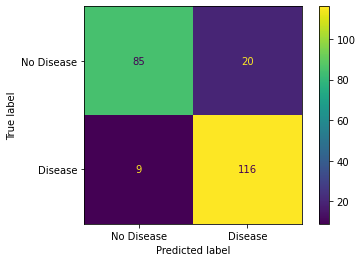

In [15]:
from sklearn.linear_model import LogisticRegressionCV

lr_l2 = LogisticRegressionCV(Cs=[1e-5,1e-4,.001,.01,1,5,10], cv=5, penalty='l2', solver='liblinear', scoring = 'recall')
lr_l2.fit(X_train_ss,y_train)
y_pred_log = lr_l2.predict(X_test_ss)
plot_confusion_matrix(lr_l2,X_test_ss, y_test,values_format='d',display_labels=["No Disease", "Disease"])

y_pred = y_pred_log
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

## With Polynomial Features

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       105
           1       0.88      0.90      0.89       125

    accuracy                           0.88       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.88      0.88      0.88       230

Accuracy score:  0.88
F1 Score:  0.89


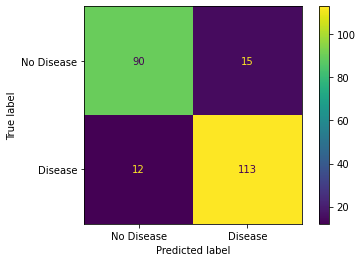

In [16]:
from sklearn.linear_model import LogisticRegressionCV

lr_l2_p2 = LogisticRegressionCV(Cs=[1e-5,1e-4,.001,.01,1,5,10], cv=5, penalty='l2', solver='liblinear', scoring = 'recall')
lr_l2_p2.fit(X2_train_ss,y2_train)
y_pred_log = lr_l2_p2.predict(X2_test_ss)

plot_confusion_matrix(lr_l2_p2,X2_test_ss, y2_test,values_format='d',display_labels=["No Disease", "Disease"])

y_pred = y_pred_log
print(classification_report(y2_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y2_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y2_test, y_pred), 2))

## I wanted to test the addition of polynomial features.  It turned out that the degree 2 features and the degree 3 features (not shown) came up with models with identical classifaction behavior.  Unfortunately, the introduction of polynomial features led to more false negatives and the model will not be used.

In [17]:
#this cell will allow me to visually inspect the failed predictions


#keep a copy of the test dataframe 
df_test = pd.DataFrame(y_test)
df_test = X_test.join(df_test)

df_log = df_test.copy()
df_log['Prediction'] = list(y_pred_log)
index = df_log[df_log['HeartDisease']!=df_log['Prediction']].index #index of false predictions from log model


log_failed_predictions = df_log.loc[index]

log_failed_predictions.sort_values('Prediction')

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,HeartDisease,Prediction
807,47,135,248,1,170,0.0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,1,0
398,60,115,0,1,143,2.4,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0.0,0.0,1.0,1,0
591,58,100,234,0,156,0.1,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,1.0,1,0
789,57,130,236,0,174,0.0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,1.0,0.0,1,0
381,58,132,224,0,173,3.2,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0.0,0.0,1.0,1,0
557,57,128,229,0,150,0.4,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0.0,1.0,0.0,1,0
382,36,120,267,0,160,3.0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,1,0
432,58,120,284,0,160,1.8,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,1.0,0.0,1,0
467,65,138,282,1,174,1.4,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0.0,1.0,0.0,1,0
881,57,154,232,0,164,0.0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,1.0,1,0


## Support Vector Machine Model

In [18]:
from sklearn.svm import SVC

### Instead of looping through the scoring metric, I am doing a few "by hand."  I want to see how each metric performs.  I think in the case of heart disease classification, the optimized model favors false positives to false negatives.

In [19]:
#all possible grid search cv metrics
import sklearn.metrics
for i in sklearn.metrics.SCORERS.keys():
    print(i)

explained_variance
r2
max_error
neg_median_absolute_error
neg_mean_absolute_error
neg_mean_absolute_percentage_error
neg_mean_squared_error
neg_mean_squared_log_error
neg_root_mean_squared_error
neg_mean_poisson_deviance
neg_mean_gamma_deviance
accuracy
top_k_accuracy
roc_auc
roc_auc_ovr
roc_auc_ovo
roc_auc_ovr_weighted
roc_auc_ovo_weighted
balanced_accuracy
average_precision
neg_log_loss
neg_brier_score
adjusted_rand_score
rand_score
homogeneity_score
completeness_score
v_measure_score
mutual_info_score
adjusted_mutual_info_score
normalized_mutual_info_score
fowlkes_mallows_score
precision
precision_macro
precision_micro
precision_samples
precision_weighted
recall
recall_macro
recall_micro
recall_samples
recall_weighted
f1
f1_macro
f1_micro
f1_samples
f1_weighted
jaccard
jaccard_macro
jaccard_micro
jaccard_samples
jaccard_weighted


ACCURACY
{'C': 8, 'gamma': 0.05, 'kernel': 'rbf'}


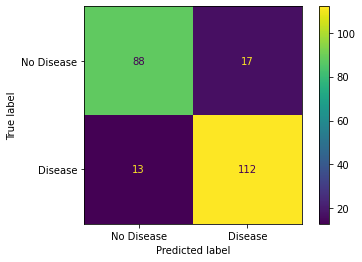

In [20]:
#Accuracy

param_grid = [
    {"C": [0.5,8,10,12],
    'gamma':['scale',0.075,0.05,.01, 0.001],
    'kernel':['rbf']}
]

print('ACCURACY')
optimal_params =GridSearchCV(
SVC(random_state=42),
param_grid,
cv=5,
scoring='accuracy'
)

optimal_params.fit(X_train_ss, y_train)
print(optimal_params.best_params_)

y_pred_a = optimal_params.predict(X_test_ss)

C_best = optimal_params.best_params_["C"]
gamma_best = optimal_params.best_params_["gamma"]
svc1 = SVC(C = C_best, gamma = gamma_best, kernel='rbf')
svc1.fit(X_train_ss,y_train)

plot_confusion_matrix(svc1,X_test_ss, y_test,values_format='d',display_labels=["No Disease", "Disease"])


F1
{'C': 8, 'gamma': 0.05, 'kernel': 'rbf'}


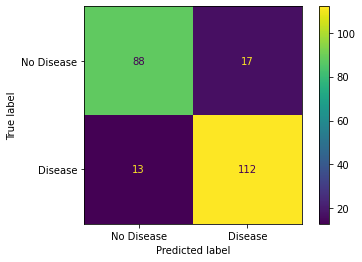

In [21]:
#f1

param_grid = [
    {"C": [.01,0.5,8,10,12],
    'gamma':['scale',0.075,0.05,.01, 0.001],
    'kernel':['rbf']}
]


print('F1')
optimal_params =GridSearchCV(
SVC(random_state=42),
param_grid,
cv=5,
scoring='f1'
)

optimal_params.fit(X_train_ss, y_train)
print(optimal_params.best_params_)

y_pred_f = optimal_params.predict(X_test_ss)

C_best = optimal_params.best_params_["C"]
gamma_best = optimal_params.best_params_["gamma"]
svc1 = SVC(C = C_best, gamma = gamma_best, kernel='rbf')
svc1.fit(X_train_ss,y_train)
plot_confusion_matrix(svc1,X_test_ss, y_test,values_format='d',display_labels=["No Disease", "Disease"])

Recall
{'C': 8, 'gamma': 0.075, 'kernel': 'rbf'}


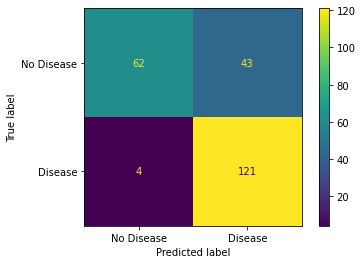

In [22]:
#RECALL with PF
param_grid = [
    {"C": [8,10,12],
    'gamma':['scale',.0075,0.075,0.05,.01, 0.001],
    'kernel':['rbf']}
]


print('Recall')
optimal_params =GridSearchCV(
SVC(random_state=42),
param_grid,
cv=5,
scoring='recall'
)

optimal_params.fit(X2_train_ss, y2_train)
print(optimal_params.best_params_)

y_pred = optimal_params.predict(X2_test_ss)

C_best = optimal_params.best_params_["C"]
gamma_best = optimal_params.best_params_["gamma"]
svc1 = SVC(C = C_best, gamma = gamma_best, kernel='rbf')
svc1.fit(X2_train_ss,y2_train)
plot_confusion_matrix(svc1,X2_test_ss, y2_test,values_format='d',display_labels=["No Disease", "Disease"])

Recall
{'C': 8, 'gamma': 0.001, 'kernel': 'rbf'}


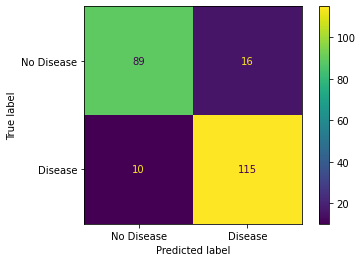

In [23]:
#RECALL
param_grid = [
    {"C": [8,10,12],
    'gamma':['scale',0.075,0.05,.01, 0.001],
    'kernel':['rbf']}
]


print('Recall')
optimal_params =GridSearchCV(
SVC(random_state=42),
param_grid,
cv=5,
scoring='recall'
)

optimal_params.fit(X_train_ss, y_train)
print(optimal_params.best_params_)

y_pred = optimal_params.predict(X_test_ss)

C_best = optimal_params.best_params_["C"]
gamma_best = optimal_params.best_params_["gamma"]
svc1 = SVC(C = C_best, gamma = gamma_best, kernel='rbf')
svc1.fit(X_train_ss,y_train)
plot_confusion_matrix(svc1,X_test_ss, y_test,values_format='d',display_labels=["No Disease", "Disease"])

In [24]:
print("zeros in test data = ", len(y_test) - sum(y_test))
print("ones in test data =", sum(y_test))

zeros in test data =  105
ones in test data = 125


In [25]:
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       105
           1       0.88      0.92      0.90       125

    accuracy                           0.89       230
   macro avg       0.89      0.88      0.89       230
weighted avg       0.89      0.89      0.89       230

Accuracy score:  0.89
F1 Score:  0.9


## Decision Tree

In [26]:
ones = sum(y_train)/len(X_train)
zeros = 1 - ones
Entropy = -ones*np.log2(ones)-zeros*np.log2(zeros)

print('Entropy in my training set = ', Entropy)

ones = sum(y_test)/len(X_test)
zeros = 1 - ones
Entropy = -ones*np.log2(ones)-zeros*np.log2(zeros)

print('Entropy in my training set = ', Entropy)

Entropy in my training set =  0.9907083887506671
Entropy in my training set =  0.9945386816500111


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

In [28]:
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)

In [29]:
dt.tree_.node_count, dt.tree_.max_depth

(217, 14)

In [30]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                              measure_error(y_test, y_test_pred, 'test')],
                              axis=1)

train_test_full_error
### END SOLUTION

,train,test
accuracy,1.0,0.813043
precision,1.0,0.841667
recall,1.0,0.808000
f1,1.0,0.824490


In [31]:
dt.feature_importances_

array([0.08638768, 0.08610971, 0.06764877, 0.01678552, 0.11938077,
       0.05665308, 0.02429922, 0.11544109, 0.00220862, 0.        ,
       0.        , 0.        , 0.00834368, 0.01563749, 0.01099402,
       0.        , 0.00294483, 0.38716553])

In [32]:
param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='recall',
                  cv = 5,
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)

In [33]:
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(15, 3)

In [34]:
y_train_pred_gr = GR.predict(X_train)
y_test_pred_gr = GR.predict(X_test)

train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_gr, 'train'),
                                 measure_error(y_test, y_test_pred_gr, 'test')],
                                axis=1)

train_test_gr_error

,train,test
accuracy,0.827035,0.808696
precision,0.823529,0.800000
recall,0.877285,0.864000
f1,0.849558,0.830769


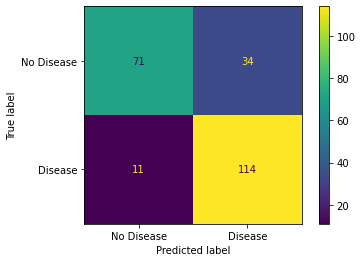

In [35]:
plot_confusion_matrix(GR,X_test_ss, y_test,values_format='d',display_labels=["No Disease", "Disease"])

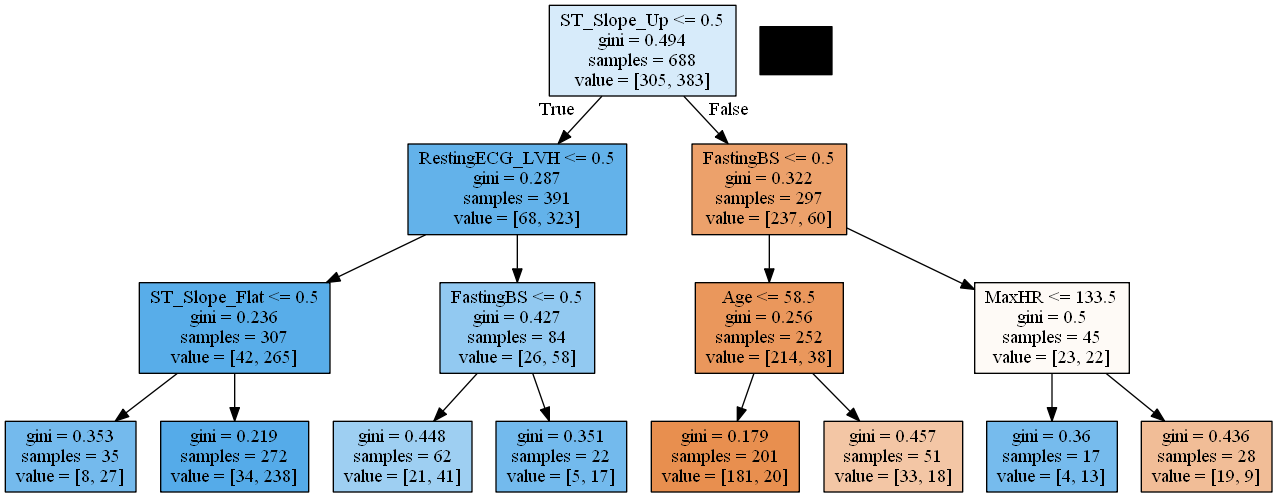

In [36]:
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(GR.best_estimator_, out_file=dot_data, filled=True,feature_names=X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# View the tree image
filename = 'heart_disease.png'
graph.write_png(filename)
Image(filename=filename) 

## SGDclassifier with Nystreom - I don't think the IBM class gave enough info on this.  Opportunity for self study.  Ignore if you are the reviewer.

In [37]:
# sg=SGDClassifier()
# sg.get_params().keys()

In [38]:
# from sklearn.kernel_approximation import Nystroem
# from sklearn.linear_model import SGDClassifier

# nystroem = Nystroem(gamma = 10, random_state=42)

# X_train_transformed = nystroem.fit_transform(X_train)
# X_test_transformed = nystroem.fit_transform(X_test)

# #X_train_transformed = st.fit_transform(X_train_transformed)
# #X_test_transformed = st.fit_transform(X_test_transformed)


# param_grid = {'loss':['hinge','log'],
#               'penalty':['l2', 'l1'],
#               'alpha':[.0001,.001,.01,.1,1,10]
    
# }

# optimal_params =GridSearchCV(
# SGDClassifier(random_state=42),
# param_grid,
# cv=5,
# scoring='f1'
# )


# optimal_params.fit(X_train_transformed,y_train)

# optimal_params.best_estimator_
# alpha_b = optimal_params.best_params_['alpha']
# loss_b = optimal_params.best_params_['loss']
# penalty_b = optimal_params.best_params_['penalty']
# SGD = SGDClassifier(alpha = alpha_b, loss = loss_b, penalty = penalty_b)
# print(alpha_b)
# SGD.fit(X_train_transformed, y_train)

# plot_confusion_matrix(SGD,X_test_transformed, y_test,values_format='d',display_labels=["No Disease", "Disease"])